# Getting Started with `bw_timex`

Here's a rundown of the steps involved in a `TimexLCA`:

<div style="display: flex; justify-content: center; background-color: white; border-radius: 15px; padding: 10px; width: 600px; margin: auto;">
  <img src="data/workflow.svg" style="border-radius: 15px; width: 100%;">
</div>

Let's walk through steps 1-4 considering a very simple dummy system:

```mermaid
flowchart LR
subgraph background[<i>background</i>]
    B("Process B"):::bg
end

subgraph foreground[<i>foreground</i>]
    A("Process A"):::fg
end

subgraph biosphere[<i>biosphere</i>]
    CO2("CO2"):::bio
end

B-->|"3 kg"|A
A-.->|"5 kg"|CO2
B-.->|"11 kg"|CO2

classDef fg color:#222832, fill:#3fb1c5, stroke:none;
classDef bg color:#222832, fill:#3fb1c5, stroke:none;
classDef bio color:#222832, fill:#9c5ffd, stroke:none;
style background fill:none, stroke:none;
style foreground fill:none, stroke:none;
style biosphere fill:none, stroke:none;
```

Setting this up with brightway:

In [1]:
# Create static system model

import bw2data as bd

bd.projects.set_current("getting_started_with_timex")

bd.Database("biosphere").write(
    {
        ("biosphere", "CO2"): {
            "type": "emission",
            "name": "CO2",
        },
    }
)

bd.Database("background_2020").write(
    {
        ("background_2020", "B"): {
            "name": "B",
            "location": "somewhere",
            "reference product": "B",
            "exchanges": [
                {
                    "amount": 1,
                    "type": "production",
                    "input": ("background_2020", "B"),
                },
                {
                    "amount": 11,
                    "type": "biosphere",
                    "input": ("biosphere", "CO2"),
                },
            ],
        },
    }
)

bd.Database("foreground").write(
    {
        ("foreground", "A"): {
            "name": "A",
            "location": "somewhere",
            "reference product": "A",
            "exchanges": [
                {
                    "amount": 1,
                    "type": "production",
                    "input": ("foreground", "A"),
                },
                {
                    "amount": 3,
                    "type": "technosphere",
                    "input": ("background_2020", "B"),
                },
                {
                    "amount": 5,
                    "type": "biosphere",
                    "input": ("biosphere", "CO2"),
                }
            ],
        },
    }
)

bd.Method(("our", "method")).write(
    [
        (("biosphere", "CO2"), 1),
    ]
)

/Users/timodiepers/Documents/Coding/bw_timex/.venv/lib/python3.13/site-packages/bw2calc/__init__.py:53: UserWarning: 
It seems like you have an ARM architecture, but haven't installed scikit-umfpack:

    https://pypi.org/project/scikit-umfpack/

Installing it could give you much faster calculations.

  warnings.warn(UMFPACK_WARNING)
100%|██████████| 1/1 [00:00<00:00, 12633.45it/s]

15:01:35+0100 [info     ] Vacuuming database            
15:01:35+0100 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.



100%|██████████| 1/1 [00:00<00:00, 17623.13it/s]

15:01:35+0100 [info     ] Vacuuming database            
15:01:35+0100 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.



100%|██████████| 1/1 [00:00<00:00, 13530.01it/s]

15:01:35+0100 [info     ] Vacuuming database            


We also need time-specific background databases. Let's say our original background system represents the year 2020, where process B emitts 11 kg CO2. By 2030, process B only emitts 7 kg CO2:

```mermaid
flowchart LR
subgraph background[<i>background</i>]
    B2020("Process B \n 2020"):::bg
    B2030("Process B \n 2030"):::bg
end

subgraph foreground[<i>foreground</i>]
    A("Process A"):::fg
end

subgraph biosphere[<i>biosphere</i>]
    CO2("CO2"):::bio
end

B2020-->|"3 kg"|A
A-.->|"5 kg"|CO2
B2020-.->|"<span style='color:#9c5ffd'><b>11 kg</b></span>"|CO2
B2030-.->|"<span style='color:#9c5ffd'><b>7 kg</b></span>"|CO2

classDef fg color:#222832, fill:#3fb1c5, stroke:none;
classDef bg color:#222832, fill:#3fb1c5, stroke:none;
classDef bio color:#222832, fill:#9c5ffd, stroke:none;
style background fill:none, stroke:none;
style foreground fill:none, stroke:none;
style biosphere fill:none, stroke:none;
```

We write this new process to a separate database:

In [2]:
# Write prospective database for 2030

bd.Database("background_2030").write(
    {
        ("background_2030", "B"): {
            "name": "B",
            "location": "somewhere",
            "reference product": "B",
            "exchanges": [
                {
                    "amount": 1,
                    "type": "production",
                    "input": ("background_2030", "B"),
                },
                {
                    "amount": 7,
                    "type": "biosphere",
                    "input": ("biosphere", "CO2"),
                },
            ],
        },
    }
)

15:01:35+0100 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 1/1 [00:00<00:00, 23301.69it/s]

15:01:35+0100 [info     ] Vacuuming database            


Finally, we need to process the databases so that the data is actually written and persistent.

In [3]:
for db in bd.databases:
    bd.Database(db).process()

> **Note:** It does not matter where your time-specific data comes from - you can also use [premise](https://premise.readthedocs.io/en/latest/introduction.html).

To save the information which background database represents which point in time, we define `database_dates`:

In [4]:
from datetime import datetime

database_dates = {
    "background_2020": datetime.strptime("2020", "%Y"),
    "background_2030": datetime.strptime("2030", "%Y"),
    "foreground": "dynamic", # no specific point in time, but should be "distributed over time"
}

## Step 1 - Adding temporal information

Temporal information on the exchange level is carried by [`TemporalDistribution`](https://docs.brightway.dev/projects/bw-temporalis/en/stable/content/api/bw_temporalis/temporal_distribution/index.html#bw_temporalis.temporal_distribution.TemporalDistribution) objects, originally introduced by [`bw_temporalis`](https://github.com/brightway-lca/bw_temporalis). 

A `TemporalDistribution` tells you what share of an exchange (*amount array*) happens at what point in time (*dates array*). 


Making up some temporal information:

```mermaid
flowchart LR
subgraph background[" "]
    B_2020(Process B \n 2020):::bg
    B_2030(Process B \n 2030):::bg
end

subgraph foreground[" "]
    A(Process A):::fg
end

subgraph biosphere[" "]
    CO2(CO2):::b
end

B_2020-->|"amounts: [30%,50%,20%] * 3 kg<br/> dates:[-2,0,+4]" years|A
A-.->|"amounts: [60%, 40%] * 5 kg<br/> dates: [0,+1]" years|CO2
B_2020-.->|"amounts: [100%] * <span style='color:#9c5ffd'><b>11 kg</b></span><br/> dates:[0]" years|CO2
B_2030-.->|"amounts: [100%] * <span style='color:#9c5ffd'><b>7 kg</b></span><br/> dates:[0]" years|CO2

classDef bg color:#222832, fill:#3fb1c5, stroke:none;
classDef fg color:#222832, fill:#3fb1c5, stroke:none;
classDef b color:#222832, fill:#9c5ffd, stroke:none;
style foreground fill:none, stroke:none;
style background fill:none, stroke:none;
style biosphere fill:none, stroke:none;

```

Pouring this into a `TemporalDistribution`:

In [5]:
import numpy as np
from bw_temporalis import TemporalDistribution

td_b_to_a = TemporalDistribution(
    date=np.array([-2, 0, 4], dtype="timedelta64[Y]"),
    amount=np.array([0.3, 0.5, 0.2]),
)

Now we add this `TemporalDistribution` to the corresponding exchange:

In [6]:
from bw_timex.utils import add_temporal_distribution_to_exchange

add_temporal_distribution_to_exchange(
    temporal_distribution=td_b_to_a, 
    input_code="B", 
    input_database="background_2020",
    output_code="A",
    output_database="foreground"
)

2026-02-23 15:01:35.741 | INFO     | bw_timex.utils:add_temporal_distribution_to_exchange:472 - Added temporal distribution to exchange Exchange: 3 None 'B' (None, somewhere, None) to 'A' (None, somewhere, None).


The same for the exchange between A and CO2:

In [7]:
td_a_to_co2 = TemporalDistribution(
    date=np.array([0, 1], dtype="timedelta64[Y]"),
    amount=np.array([0.6, 0.4]),
)

# We actually only have to define enough fields to uniquely identify the exchange here
add_temporal_distribution_to_exchange(
    temporal_distribution=td_a_to_co2, 
    input_code="CO2", 
    output_code="A"
)

2026-02-23 15:01:35.749 | INFO     | bw_timex.utils:add_temporal_distribution_to_exchange:472 - Added temporal distribution to exchange Exchange: 5 None 'CO2' (None, None, None) to 'A' (None, somewhere, None).


### Temporal evolution of foreground exchanges (optional)

The temporal distributions above tell us *when* exchanges happen. But what if the *amount* of an exchange also changes over time? For example, Process A might become more efficient and require less input from Process B in later years.

`bw_timex` supports this via optional **temporal evolution** attributes on exchanges. You can specify either **scaling factors** or **absolute amounts** at specific points in time — values are linearly interpolated in between and clamped at the boundaries.

> **Note:** This is entirely optional. If you don't add temporal evolution, exchange amounts stay constant over time as before. Temporal evolution only applies to foreground exchanges — background evolution is already handled by the database interpolation.

In [8]:
# Example: the exchange from B to A becomes 25% more efficient by 2030
from bw_timex.utils import add_temporal_evolution_to_exchange

add_temporal_evolution_to_exchange(
    temporal_evolution_factors={
        datetime(2020, 1, 1): 1.0,   # 100% of base amount in 2020
        datetime(2030, 1, 1): 0.75,  # 75% of base amount in 2030
    },
    input_code="B",
    input_database="background_2020",
    output_code="A",
    output_database="foreground",
)

# Alternatively, you can specify absolute amounts directly:
# add_temporal_evolution_to_exchange(
#     temporal_evolution_amounts={
#         datetime(2020, 1, 1): 3.0,    # 3 kg in 2020
#         datetime(2030, 1, 1): 2.25,   # 2.25 kg in 2030
#     },
#     input_code="B",
#     input_database="background_2020",
#     output_code="A",
#     output_database="foreground",
# )

2026-02-23 15:01:35.764 | INFO     | bw_timex.utils:add_temporal_evolution_to_exchange:502 - Added temporal evolution to exchange Exchange: 3 None 'B' (None, somewhere, None) to 'A' (None, somewhere, None).


## Step 2 - Building the timeline 

Now we can instantiate a `TimexLCA` object - similarly to a normal Brightway LCA object, but with the additional argument of our `database_dates`.

Our demand will be the product of process A:

In [9]:
from bw_timex import TimexLCA

tlca = TimexLCA(
    demand={("foreground", "A"): 1},
    method=("our", "method"),
    database_dates=database_dates,
)

2026-02-23 15:01:35.768 | INFO     | bw_timex.timex_lca:__init__:114 - Initializing TimexLCA object...
2026-02-23 15:01:35.768 | INFO     | bw_timex.timex_lca:__init__:136 - Collecting node infos...


Building the timeline is very simple now. To define when the demand occurs, you can specify a `starting_datetime` (default is "now"):

In [10]:
tlca.build_timeline(starting_datetime="2024-01-01")

2026-02-23 15:01:35.774 | INFO     | bw_timex.timex_lca:build_timeline:216 - No edge filter function provided. Skipping all edges in background databases.
2026-02-23 15:01:35.775 | INFO     | bw_timex.timex_lca:build_timeline:232 - Calculating base LCA...
2026-02-23 15:01:35.788 | INFO     | bw_timex.timex_lca:build_timeline:242 - Creating activity time mapping...
2026-02-23 15:01:35.789 | INFO     | bw_timex.timeline_builder:__init__:99 - Traversing supply chain graph...
2026-02-23 15:01:35.792 | INFO     | bw_timex.timeline_builder:build_timeline:142 - Building timeline...


Starting graph traversal
Calculation count: 1


,date_producer,producer_name,date_consumer,consumer_name,amount,temporal_market_shares
0,2022-01-01,B,2024-01-01,A,0.9,"{'background_2020': 0.8, 'background_2030': 0.2}"
1,2024-01-01,B,2024-01-01,A,1.5,"{'background_2020': 0.6, 'background_2030': 0.4}"
2,2024-01-01,A,2024-01-01,-1,1.0,None
3,2028-01-01,B,2024-01-01,A,0.6,"{'background_2020': 0.2, 'background_2030': 0.8}"


The timeline tells us which exchange happens at what time. 

Also, we see the "temporal_market_shares", already giving a hint on how the processes will be re-linked in the next step. For the first row of the timeline, the interpolation weights are:

In [11]:
tlca.timeline.temporal_market_shares[0]

{'background_2020': 0.8, 'background_2030': 0.2}

## Step 3 - Calculating the time-explicit LCI

Calculating the time-explicit LCI from the timeline is very simple, at least from the user perspective:


In [12]:
tlca.lci()

2026-02-23 15:01:35.820 | INFO     | bw_timex.timex_lca:lci:360 - Expanding matrices...
2026-02-23 15:01:35.823 | INFO     | bw_timex.timex_lca:lci:379 - Calculating dynamic inventory...


Under the hood, before solving the inventory problem, we're re-build the technosphere and biosphere matrices here. More specifically, we add new rows and columns to carry the extra temporal information. Details are explained in the [Theory Section](https://docs.brightway.dev/projects/bw-timex/en/latest/content/theory.html#modifying-the-matrices) of our docs.

## Step 4 - Impact assessment

The impact assessment can be very simple now. To characterize the inventory with the impact assessment method that we initially chose when creating our `TimexLCA`, we can simply call:

In [13]:
tlca.static_lcia()
tlca.static_score

30.1550698056392

But there's more: Because a `TimexLCA` retains temporal information in the inventory, it also allows for dynamic characterization. To help with that, we created another package, simply called [`dynamic_characterization`](https://dynamic-characterization.readthedocs.io/en/latest/). This is not today's topic, but here's a quick demo:

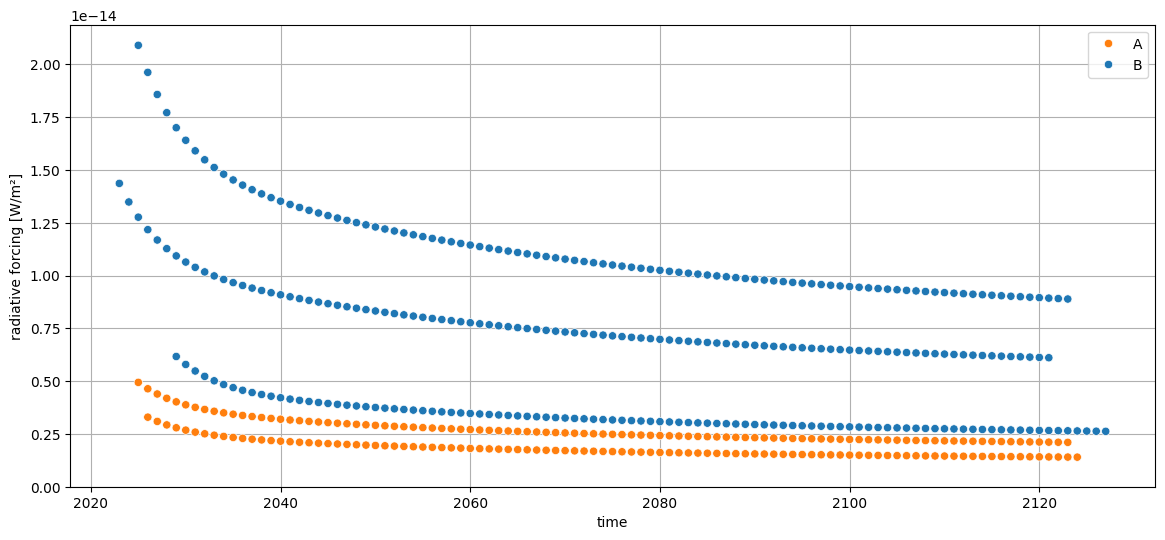

In [14]:
from dynamic_characterization.ipcc_ar6 import characterize_co2 # <- dynamic characterization function
emission_id = bd.get_activity(("biosphere", "CO2")).id

# defining which characterization function to use for which emission
characterization_functions = {
    emission_id: characterize_co2,
}

# characterizing the inventory
tlca.dynamic_lcia(
    metric="radiative_forcing",
    time_horizon=100,
    characterization_functions=characterization_functions,
)

tlca.plot_dynamic_characterized_inventory()

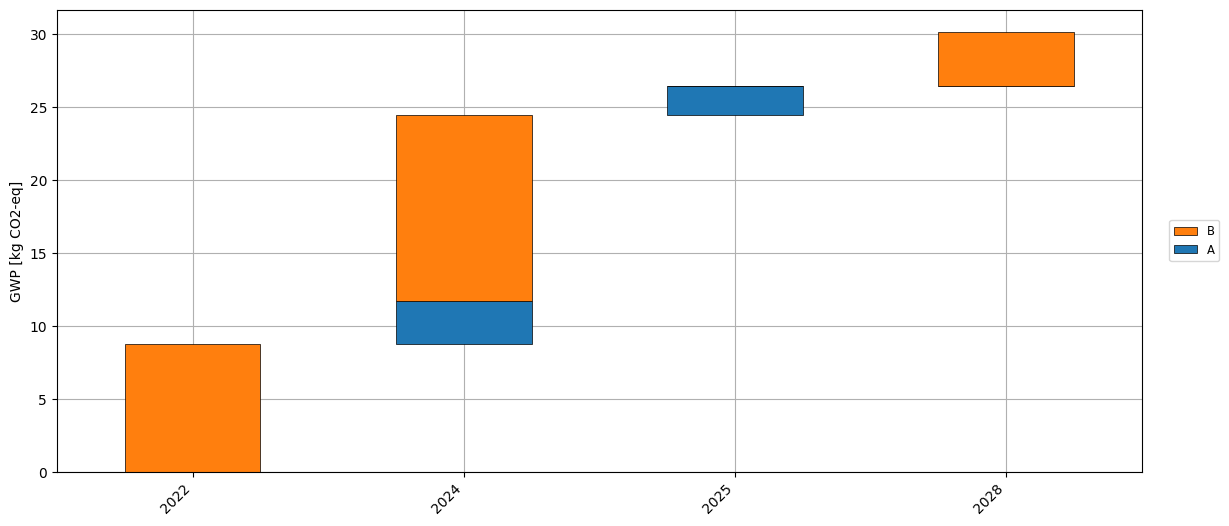

In [15]:
from bw_timex.utils import plot_characterized_inventory_as_waterfall

tlca.dynamic_lcia(
    metric="GWP",
    time_horizon=100,
    characterization_functions=characterization_functions,
)

plot_characterized_inventory_as_waterfall(tlca)


## Quick Recap
This might have seemed quite lengthy now. But essentially, calculating a `TimexLCA` is just this:

In [17]:
tlca = TimexLCA(
    demand={("foreground", "A"): 1},
    method=("our", "method"),
    database_dates=database_dates,
)
tlca.build_timeline()
tlca.lci()
tlca.static_lcia()
tlca.static_score

2026-02-23 15:01:43.740 | INFO     | bw_timex.timex_lca:__init__:114 - Initializing TimexLCA object...
2026-02-23 15:01:43.741 | INFO     | bw_timex.timex_lca:__init__:136 - Collecting node infos...
2026-02-23 15:01:43.745 | INFO     | bw_timex.timex_lca:build_timeline:216 - No edge filter function provided. Skipping all edges in background databases.
2026-02-23 15:01:43.745 | INFO     | bw_timex.timex_lca:build_timeline:232 - Calculating base LCA...
2026-02-23 15:01:43.752 | INFO     | bw_timex.timex_lca:build_timeline:242 - Creating activity time mapping...
2026-02-23 15:01:43.753 | INFO     | bw_timex.timeline_builder:__init__:99 - Traversing supply chain graph...
2026-02-23 15:01:43.757 | INFO     | bw_timex.timeline_builder:build_timeline:142 - Building timeline...
2026-02-23 15:01:43.770 | INFO     | bw_timex.timex_lca:lci:360 - Expanding matrices...
2026-02-23 15:01:43.774 | INFO     | bw_timex.timex_lca:lci:379 - Calculating dynamic inventory...


Starting graph traversal
Calculation count: 1


26.728939228031752

For most of the functions we used here, there are numerous optional arguments and settings you can tweak. We explore some of them in our other [Examples](https://docs.brightway.dev/projects/bw-timex/en/latest/content/examples/index.html), but when in doubt: Our code is pretty well documented, see our [API Reference](https://docs.brightway.dev/projects/bw-timex/en/latest/content/api/index.html) - so please browse through that as needed ☀️